<a href="https://colab.research.google.com/github/shaya-686/AI/blob/main/notebook04b2e125cf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ga-customer-revenue-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F10038%2F180088%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240711%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240711T171316Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D53dfa782ef4002a44852204b3f6ce3b23c013039bf92ff4d46888e31c2d52b4d82b778a14e3987087c9b6efbaa62ba3f68bb484c3963bad505fae38afcad3cd7919eaefac962d2693292c121d4d8d2cab802b088c1937023a19cc203729342a8895ca07ce6a9b91f1e13d5aff3a87d22e0066ffa1adf660f82d633a5dcc6a704ce64e4990b7137f228e39a7605505a00c4eea49ff82b97e6ae4ae3dc8d33929139d648d72d3a94b5cb2a6e354510f0427ac7fcff494784d09cb172d3bccb4c1395c8ea031e8433ec449fc6b1316e834c23c601c4d52c62b8346f3411558b7a7718e967f62707ea973a56fe29d318cc28e10eb1d2da6dfd8d3232e43f1ebc9bd1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1675109269 bytes downloaded
Downloaded and uncompressed: ga-customer-revenue-prediction
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ga-customer-revenue-prediction/train_v2.csv
/kaggle/input/ga-customer-revenue-prediction/sample_submission_v2.csv
/kaggle/input/ga-customer-revenue-prediction/test.csv
/kaggle/input/ga-customer-revenue-prediction/sample_submission.csv
/kaggle/input/ga-customer-revenue-prediction/test_v2.csv
/kaggle/input/ga-customer-revenue-prediction/train.csv


In [4]:
import json
import pandas as pd


def load_df(csv_path='/kaggle/input/ga-customer-revenue-prediction/train_v2.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)

    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    df.drop(columns=['customDimensions', 'hits'], inplace=True)

    df = df.fillna({'totals_pageviews':0,
                    'totals_transactionRevenue':0,
                    'totals_pageviews':0})

    df['device_isMobile'] = df['device_isMobile'].astype(int)
    df['totals_transactionRevenue'] = df['totals_transactionRevenue'].astype(int)

    cat_col = df.select_dtypes(include='object').columns

    df[cat_col] = df[cat_col].astype(str)

    return df


df = load_df('/kaggle/input/ga-customer-revenue-prediction/train_v2.csv', nrows=100_000)

In [5]:
df.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserVersion,device_browserSize,...,trafficSource_keyword,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_referralPath,trafficSource_isTrueDirect,trafficSource_adContent,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.isVideoAd
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,...,water bottle,not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,...,nan,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,nan,nan,nan,nan,nan,nan,nan
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,...,nan,not available in demo dataset,nan,True,nan,nan,nan,nan,nan,nan
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,...,(not provided),not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,...,(not provided),not available in demo dataset,nan,nan,nan,nan,nan,nan,nan,nan


In [6]:
!pip install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.6 MB/s eta 0:00:00


In [7]:
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
import lightgbm as lgb
import optuna

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 57 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    100000 non-null  object
 1   date                                               100000 non-null  int64 
 2   fullVisitorId                                      100000 non-null  object
 3   socialEngagementType                               100000 non-null  object
 4   visitId                                            100000 non-null  int64 
 5   visitNumber                                        100000 non-null  int64 
 6   visitStartTime                                     100000 non-null  int64 
 7   device_browser                                     100000 non-null  object
 8   device_browserVersion                              100000 non-null  object
 9   devic

In [9]:
df.select_dtypes(include = 'number').describe()

,date,visitId,visitNumber,visitStartTime,device_isMobile,totals_transactionRevenue
count,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,100000.000000,1.000000e+05
mean,2.017052e+07,1.498890e+09,2.333650,1.498890e+09,0.310740,1.187122e+06
std,6.797216e+03,1.625577e+07,8.991106,1.625577e+07,0.462799,2.841594e+07
min,2.016081e+07,1.470896e+09,1.000000,1.470899e+09,0.000000,0.000000e+00
25%,2.016121e+07,1.481673e+09,1.000000,1.481673e+09,0.000000,0.000000e+00
50%,2.017062e+07,1.498295e+09,1.000000,1.498295e+09,0.000000,0.000000e+00
75%,2.017113e+07,1.512092e+09,1.000000,1.512092e+09,1.000000,0.000000e+00
max,2.018043e+07,1.525072e+09,401.000000,1.525072e+09,1.000000,5.498000e+09


In [46]:
y = df['totals_transactionRevenue']
X = df.drop(columns='totals_transactionRevenue')

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  train_size=0.75,
                                                  random_state=42)

print(f'Train: {X_train.shape[0]} samples \t {round(X_train.shape[0] / X.shape[0] * 100)}%')
print(f'Test:  {X_test.shape[0]} samples \t {round(X_test.shape[0] / X.shape[0] * 100)}%')
print(f'Val:   {X_val.shape[0]} samples \t {round(X_val.shape[0] / X.shape[0] * 100)}%')

Train: 60000 samples 	 60%
Test:  20000 samples 	 20%
Val:   20000 samples 	 20%


In [48]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

In [49]:
num_columns = X.select_dtypes(include="number").columns
cat_columns = X.select_dtypes(include="object").columns

# числові ознаки
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median"))]
    )

# категоріальні ознаки
cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan))])

# об'єднання двох pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns),
    ]
)

preprocessor.set_output(transform='pandas')
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['date', 'visitId', 'visitNumber', 'visitStartTime', 'device_isMobile'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))])...
       'trafficSource_adwordsClickInfo.criteriaParameters',
       'trafficSource_referralPath', 'trafficSource_isTrueDirect',
       'trafficSource_adContent', 'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.isVideoAd'],
      dtype='object'))])

In [50]:
# навчання препроцесора
X_train = preprocessor.fit_transform(X_train)

# обробка даних
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [81]:
from sklearn import metrics


def objective(trial):
  """
  Функція objective для Optuna, яка навчає модель LightGBMRegressor
  на тренувальному наборі даних та оцінює її на тестовому наборі.

  Args:
      trial (optuna.Trial): Об'єкт Optuna, що представляє один набір гіперпараметрів.

  Returns:
      float: Значення метрики оцінки (R2).
  """

  # 1. Визначення гіперпараметрів:

  # params1 = {
  #       'objective': 'mse',
  #       'n_estimator': 30,
  #       'verbose': -1,
  #       'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
  #       'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
  #       'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
  #       'num_leaves': trial.suggest_int('num_leaves', 2, 256),
  #       'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
  #       'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
  #       'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
  #       'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
  #   }

  params = {
    'objective': 'mse',
    'n_estimators': 10,
    'verbose': -1,
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    #'num_leaves': trial.suggest_int('num_leaves', 2, 256),
    #'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
    #'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    #'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
    #'subsample': trial.suggest_float('subsample', 0.4, 1.0),
    #'subsample_freq': trial.suggest_int('subsample_freq', 1, 10),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
    #'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 100.0, log=True),
    }

  # 2. Створення моделі LightGBMRegressor:

  model = lgb.LGBMRegressor(**params)

  # 3. Навчання моделі на тренувальному наборі даних:

  model.fit(X_train, y_train)

  # 4. Оцінка моделі на тестовому наборі даних:

  y_pred = model.predict(X_val)
  r2 = metrics.r2_score(y_val, y_pred)
  mae = metrics.mean_absolute_error(y_val, y_pred)
  rmse = metrics.mean_squared_error(y_val, y_pred) ** 0.5

  # 5. Повернення значення метрики:
  return r2, mae, rmse

In [82]:
#optuna.logging.set_verbosity(optuna.logging.WARNING) # щоб не виводило інформацію про trial

study = optuna.create_study(directions=['maximize', 'minimize', 'minimize'])
study.optimize(objective, n_trials=10)

[I 2024-07-11 18:30:40,130] A new study created in memory with name: no-name-959a26c0-72be-4353-af63-0a3b45dcc761
[I 2024-07-11 18:30:40,709] Trial 0 finished with values: [0.21891170873442667, 1756851.9613564156, 20915246.71587771] and parameters: {'boosting_type': 'dart', 'lambda_l1': 3.600996464126535e-07, 'lambda_l2': 0.07878206832454165, 'bagging_freq': 3, 'learning_rate': 0.08204801282884218, 'colsample_bytree': 0.517422641075559}. 
[I 2024-07-11 18:30:41,273] Trial 1 finished with values: [0.13788955332815112, 2035000.4399601284, 21973254.300069828] and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 6.396973302816046e-06, 'lambda_l2': 2.943792578458594e-07, 'bagging_freq': 4, 'learning_rate': 0.0337863690314659, 'colsample_bytree': 0.4968500646246396}. 
[I 2024-07-11 18:30:41,794] Trial 2 finished with values: [-0.18310093419739282, 2333302.3245010683, 25740905.883602396] and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.0004672387308785822, 'lambda_l2': 7.25322117740

In [68]:
#print(f"найкраща метрика: {study.best_value}")

In [83]:
data = pd.DataFrame([trial.values for trial in study.best_trials],
                    columns=['r2', 'mae', 'rmse'])

data

,r2,mae,rmse
0,0.218912,1.756852e+06,2.091525e+07


In [84]:
best_params = study.best_trials[0].params

In [85]:
best_params

{'boosting_type': 'dart',
 'lambda_l1': 3.600996464126535e-07,
 'lambda_l2': 0.07878206832454165,
 'bagging_freq': 3,
 'learning_rate': 0.08204801282884218,
 'colsample_bytree': 0.517422641075559}

In [86]:
model = lgb.LGBMRegressor(**best_params,
                          n_estimator = 10,
                          verbose=-1)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_train, y_train)],
          eval_metric='mae')

LGBMRegressor(bagging_freq=3, boosting_type='dart',
              colsample_bytree=0.517422641075559,
              lambda_l1=3.600996464126535e-07, lambda_l2=0.07878206832454165,
              learning_rate=0.08204801282884218, n_estimator=10, verbose=-1)

In [87]:
def get_metrics(y_true, y_pred, name="model"):
  df = pd.DataFrame()

  df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
  df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
  df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

  return df.round(2)

In [88]:
all_metrics = pd.DataFrame()

all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
all_metrics["test"] = get_metrics(y_test, model.predict(X_test))

all_metrics

,train,test
MAE,1109530.37,1272661.07
RMSE,23803445.95,16637396.77
R2,0.45,0.29


In [89]:
optuna.visualization.plot_param_importances(study)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

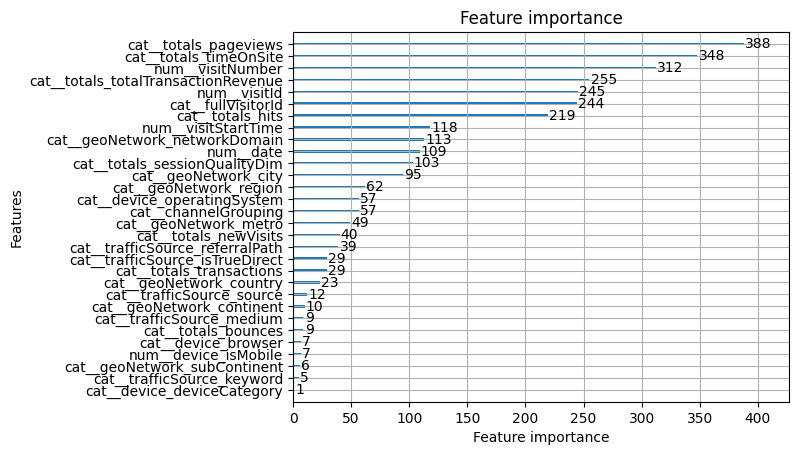

In [90]:
lgb.plot_importance(model)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

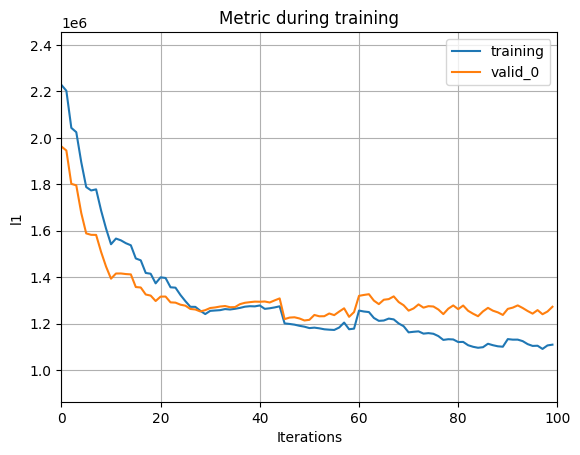

In [91]:
lgb.plot_metric(model,
                metric='l1')

In [44]:
model = Pipeline(
    [("prep", preprocessor),
     ("model", model)
     ]
)

model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['date', 'visitId', 'visitNumber', 'visitStartTime', 'device_isMobile'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_valu...
                               bagging_freq=3, boosting_type='dart',
                               colsample_bytree=0.6765709210560042,
                               feature_fraction=0.5151844854488303,
                               lambda_l1=0.1479547623134326,
                               lambda_l2=0.0009710616832709334,
                               learning_rate=0.20539627623606754,
                               min_child_samples=50,
                               min_child_weight=0.0023569067958221245,
                               n_estimator=100, num_leaves=99,
                               subsample=0.8889022705100836, subsample_freq=4,
                               verbose=-1))])